In [10]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [46]:
# Problem parameters
N = 5                # number of agents
H = 10               # time horizon (number of steps)
L_init = np.random.uniform(20, 40, size=N)       # initial battery load for each agent
L_target = np.random.uniform(80, 90, size=N)     # target final load (same for all agents)
E = np.random.uniform(5, 15, size=H)   # net energy profile at each step

# ADMM parameters
rho = 3.0            # penalty parameter
max_iter = 300       # maximum ADMM iterations
abs_tol = 1e-3       # primal residual tolerance
rel_tol = 1e-3       # dual residual tolerance

# Initialization
l = np.zeros((N, H))
r = np.zeros((N, H))
L = np.zeros((N, H+1))
L[:, 0] = L_init

u_l = np.zeros((N, H))
u_r = np.zeros((N, H))
z_l = np.zeros(H)
z_r = np.zeros(H)

history = []

# ADMM loop
for iteration in range(1, max_iter+1):
    for i in range(N):
        l_var = cp.Variable(H, nonneg=True)
        r_var = cp.Variable(H, nonneg=True)
        L_var = cp.Variable(H+1)

        constraints = [L_var[0] == L_init[i]]
        for h in range(H):
            constraints += [L_var[h+1] == L_var[h] + l_var[h] - r_var[h]]

        obj_terms = [(L_var[H] - L_target[i])**2,
                     (rho/2) * cp.sum_squares(l_var - z_l + u_l[i]),
                     (rho/2) * cp.sum_squares(r_var - z_r + u_r[i])]
        objective = cp.Minimize(cp.sum(obj_terms))
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP, warm_start=True)

        l[i, :] = l_var.value
        r[i, :] = r_var.value
        L[i, :] = L_var.value

    l_avg = np.mean(l + u_l, axis=0)
    r_avg = np.mean(r + u_r, axis=0)
    z_l_new = (l_avg + r_avg + E) / 2.0
    z_r_new = z_l_new - E

    for i in range(N):
        u_l[i] += (l[i] - z_l_new)
        u_r[i] += (r[i] - z_r_new)

    r_primal = sum(np.linalg.norm(l[i] - z_l_new) + np.linalg.norm(r[i] - z_r_new) for i in range(N))
    if iteration == 1:
        r_dual = np.inf
    else:
        r_dual = rho * (np.linalg.norm(z_l_new - z_l) + np.linalg.norm(z_r_new - z_r)) * np.sqrt(N)

    eps_primal = np.sqrt(N * H) * abs_tol + rel_tol * max(np.linalg.norm(l), np.linalg.norm(z_l_new))
    eps_dual = np.sqrt(N * H) * abs_tol + rel_tol * np.linalg.norm(np.vstack([u_l, u_r]))

    history.append((iteration, r_primal, eps_primal, r_dual, eps_dual))
    print(f"Iteration: {iteration}; primal {r_primal}; dual {r_dual}")
    if (r_primal < eps_primal) and (r_dual < eps_dual):
        break

    z_l = z_l_new.copy()
    z_r = z_r_new.copy()

final_loads = L[:, -1]
final_results = {f"Agent {i}": final_loads[i] for i in range(N)}
final_results["Target"] = L_target

Iteration: 1; primal 88.33282783832273; dual inf
Iteration: 2; primal 60.68713832302195; dual 62.80090570887229
Iteration: 3; primal 57.34664001175905; dual 20.551457596062402
Iteration: 4; primal 50.24396798092454; dual 2.6591520643413147
Iteration: 5; primal 45.44077792025591; dual 0.6414602916995809
Iteration: 6; primal 42.23443214565353; dual 1.7683440982651317
Iteration: 7; primal 39.30998372348311; dual 2.6583296951973896
Iteration: 8; primal 36.57134790176276; dual 2.8982882021967056
Iteration: 9; primal 34.021794797586566; dual 2.847487975943159
Iteration: 10; primal 31.65946007681528; dual 2.68156408950519
Iteration: 11; primal 29.461220164475577; dual 2.571041403590367
Iteration: 12; primal 27.411001587472427; dual 2.5491521723378447
Iteration: 13; primal 25.494099064792927; dual 2.4192397467911415
Iteration: 14; primal 23.70320533927832; dual 2.212506752155758
Iteration: 15; primal 22.036336233114916; dual 1.9936183504516212
Iteration: 16; primal 20.4881348595951; dual 1.805

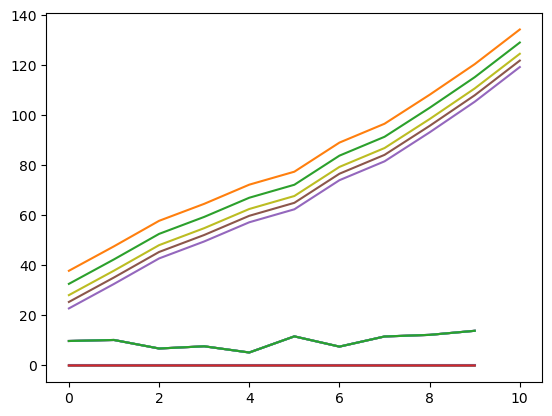

In [48]:
for n in range(N):
    plt.plot(l[n])
    plt.plot(r[n])
    plt.plot(L[n])
    

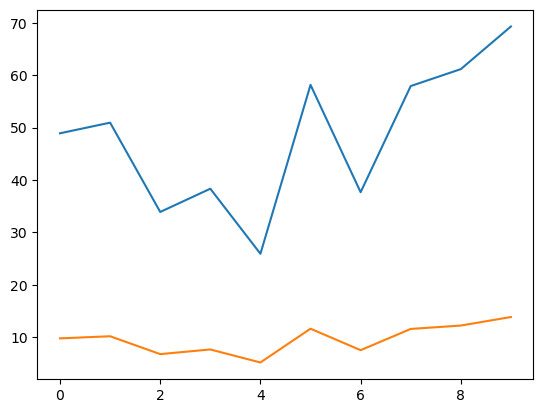

In [50]:
plt.plot(np.sum(l,axis=0)-np.sum(r, axis=0))
plt.plot(E)